<a href="https://colab.research.google.com/github/Chicken2322/Stock-Prediction/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
#setting scaler in the the range between 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))

In [22]:
df = pd.read_csv("/content/drive/My Drive/RELIANCE.NS.csv")

In [23]:
df.columns
df.head()
df.info()
df.size


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       246 non-null    object 
 1   Open       245 non-null    float64
 2   High       245 non-null    float64
 3   Low        245 non-null    float64
 4   Close      245 non-null    float64
 5   Adj Close  245 non-null    float64
 6   Volume     245 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.6+ KB


1722

In [24]:
#We are converting date into date_time objects and setting it as index
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.sort_index(ascending=True, axis=0)

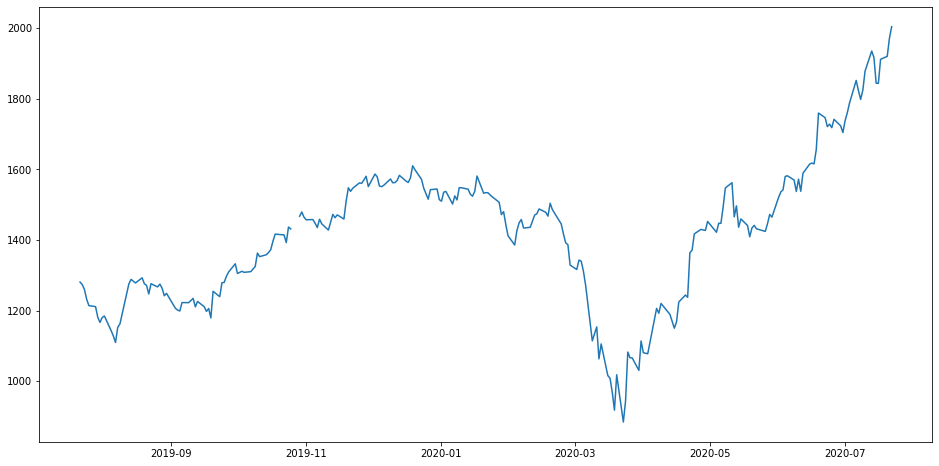

In [25]:
#plotting the closing price of the company 
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [27]:
#Now we are analysing our data by Moving Average Method and creating dataframe with date  
#and the target variable( In this case , CLOSING PRICE)
data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
data.columns

Index(['Date', 'Close'], dtype='object')